In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [4]:
#df = pd.read_csv('/host/data/data_exploration_output_1000lines.csv')
#df = pd.read_csv('data_exploration_filtered_lat.csv')

df = pd.read_csv('../auth_filtered_all_with_labels_sorted_2_with_labels_filtered.csv')

#cols = ["time","p(src_user)","p(dest_user)","p(src_nt_host)","p(dest_nt_host)","p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)"]
#cols = ["p(src_user)","p(dest_user)","p(src_nt_host)","p(dest_nt_host)","p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)", "is_malicious"]
cols = ["p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)", "is_malicious"]

df = df[cols]

print("DF Shape: " + str(df.shape))

DF Shape: (10000704, 7)


In [6]:
scaler = StandardScaler()

In [7]:
df[["p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)"]] = scaler.fit_transform(df.as_matrix(["p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)"]))

In [8]:
df.head(1)

,p(src_user n dest_user),p(src_nt_host n dest_nt_host),p(dest_user n dest_nt_host),p(src_nt_host|dest_nt_host),p(dest_user|src_user),p(dest_nt_host|dest_user),is_malicious
0,0.096296,-1.24314,-0.24271,-1.141385,0.795777,-1.367526,0


In [32]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model
import matplotlib.pyplot as plt

In [16]:
TEST_RATIO = 0.25
#df.sort_values('time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
#train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_x = df.iloc[:TRA_INDEX, 0:-1].values
#train_x = df.iloc[:TRA_INDEX, :].values
train_y = df.iloc[:TRA_INDEX, -1].values
#train_y = df.iloc[:TRA_INDEX, :].values

#test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_x = df.iloc[TRA_INDEX:, 0:-1].values
#test_x = df.iloc[TRA_INDEX:, :].values
test_y = df.iloc[TRA_INDEX:, -1].values
#test_y = df.iloc[TRA_INDEX:, :].values

In [20]:
# this is the size of our encoded representations
encoding_dim = 3

# this is our input placeholder
input_ph = Input(shape=(6,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_ph)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(6, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_ph, decoded)

In [21]:
# this model maps an input to its encoded representation
encoder = Model(input_ph, encoded)

In [22]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [37]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=1,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [51]:
history = autoencoder.fit(train_x, train_x,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(test_x, test_x),
                callbacks=[checkpointer, tensorboard]).history

Train on 7500528 samples, validate on 2500176 samples
Epoch 1/10
7500528/7500528 [==============================] - 54s 7us/step - loss: 0.5946 - acc: 0.6308 - val_loss: 0.5619 - val_acc: 0.6826

Epoch 00001: val_loss improved from 0.56194 to 0.56194, saving model to model.h5
Epoch 2/10
7500528/7500528 [==============================] - 53s 7us/step - loss: 0.5946 - acc: 0.6308 - val_loss: 0.5619 - val_acc: 0.6826

Epoch 00002: val_loss improved from 0.56194 to 0.56194, saving model to model.h5
Epoch 3/10
7500528/7500528 [==============================] - 54s 7us/step - loss: 0.5946 - acc: 0.6308 - val_loss: 0.5619 - val_acc: 0.6824

Epoch 00003: val_loss improved from 0.56194 to 0.56194, saving model to model.h5
Epoch 4/10
7500528/7500528 [==============================] - 55s 7us/step - loss: 0.5946 - acc: 0.6307 - val_loss: 0.5619 - val_acc: 0.6824

Epoch 00004: val_loss improved from 0.56194 to 0.56193, saving model to model.h5
Epoch 5/10
7500528/7500528 [==========================

In [54]:
autoencoder = load_model('model.h5')

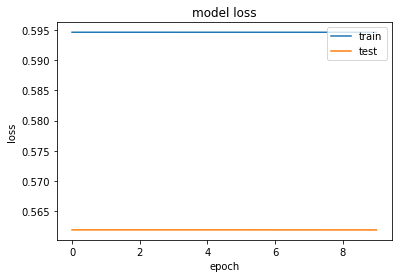

In [55]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()